## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
#print(APInames.keys())

65


In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

In [110]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'NPM1'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:4869
all relevant predicates in Translator:
['biolink:derives_from', 'biolink:interacts_with', 'biolink:is_substrate_of', 'biolink:coexists_with', 'biolink:affects_response_to', 'biolink:affects', 'biolink:gene_product_of', 'biolink:has_substrate', 'biolink:associated_with_resistance_to', 'biolink:genetic_association', 'biolink:has_gene_product', 'biolink:increases_response_to', 'biolink:directly_physically_interacts_with', 'biolink:negatively_correlated_with', 'biolink:regulates', 'biolink:has_part', 'biolink:affected_by', 'biolink:binds', 'biolink:resistance_associated_with', 'biolink:part_of', 'biolink:disrupts', 'biolink:sensitivity_associated_with', 'biolink:causes', 'biolink:correlated_with', 'biolink:associated_with_sensitivity_to', 'biolink:occurs_together_in_literature_with', 'biolink:derives_into', 'biolink:decreases_response_to', 'biolink:response_affected_by', 'biolink:produces', 'biolink:genetically_associated_with', 'biolink:related_to', 'biolink:produced_by', 'b

In [106]:
# Step 3: set input parameters
# Test multiomics Wellness KP

# Node1 for query
input_node1 = "LOINC:5685-3"
#input_node1_id = TCT.get_curie(input_node1)
input_node1_id = input_node1
input_node1_list = [input_node1_id]
input_node1_category = ["biolink:ClinicalFinding"]
#Node2 for query
input_node2_list = []
input_node2_category = ["biolink:SmallMolecule", "biolink:ClinicalFinding"]
                        
# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

all relevant predicates in Translator:
['biolink:correlated_with']
all relevant APIs in Translator:
['Biothings Explorer (BTE)', 'Service Provider TRAPI', 'Multiomics Wellness KP API']
3


In [112]:
# Step 3: set input parameters
# Test multiomics EHR KP

# Node1 for query
input_node1 = "chronic myelomonocytic leukemia"
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]

input_node1_category = ["biolink:Disease"]
#Node2 for query
input_node2_list = []
input_node2_category = ["biolink:PhenotypicFeature", "biolink:Disease"]
                        
# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

MONDO:0020311
all relevant predicates in Translator:
['biolink:is_exacerbated_by', 'biolink:located_in', 'biolink:is_diagnosed_by', 'biolink:coexists_with', 'biolink:affects', 'biolink:gene_associated_with_condition', 'biolink:phenotype_of', 'biolink:associated_with', 'biolink:negatively_correlated_with', 'biolink:predisposes', 'biolink:has_part', 'biolink:affected_by', 'biolink:location_of', 'biolink:subclass_of', 'biolink:similar_to', 'biolink:contains_process', 'biolink:caused_by', 'biolink:has_predisposing_factor', 'biolink:part_of', 'biolink:has_manifestation', 'biolink:preceded_by', 'biolink:causes', 'biolink:manifestation_of', 'biolink:correlated_with', 'biolink:occurs_together_in_literature_with', 'biolink:contribution_from', 'biolink:diagnoses', 'biolink:contributes_to', 'biolink:has_real_world_evidence_of_association_with', 'biolink:exacerbates', 'biolink:superclass_of', 'biolink:precedes', 'biolink:related_to', 'biolink:occurs_in', 'biolink:positively_correlated_with', 'biol

In [108]:
# Test clinical trial KP
# Step 3: set input parameters

# Node1 for query
input_node1 = "amyloidosis"
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)

#input_node1_id = "UMLS:C0010583"
input_node1_list = [input_node1_id]

input_node1_category = ['biolink:DiseaseorPhenotypicFeature', 'biolink:Disease']
#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Treatment']
                        
# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

MONDO:0019065
all relevant predicates in Translator:
['biolink:related_to']
all relevant APIs in Translator:
['Biothings Explorer (BTE)', 'Service Provider TRAPI', 'Multiomics ClinicalTrials KP']
3


Warning Code:404:https://api.bte.ncats.io/v1/1c056ffc7ed0dd1229e71c4752239465/query
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:404:https://automat.renci.org/biolink/1.4/query
Warning Code:400:https://ars-prod.transltr.io/ara-robokop/api/runqueryWarning Code:404:https://automat.ci.transltr.io/sri-reference-kp/1.4/query

'https://automat.ci.renci.org/drugcentral/1.4/query' generated an exception: HTTPSConnectionPool(host='automat.ci.renci.org', port=443): Max retries exceeded with url: /drugcentral/1.4/query (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x1496d5f00>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Success!https://automat.renci.org/hmdb/1.4/query
Warning Code:404:https://automat.ci.transltr.io/ubergraph-nonredundant/1.4/query
Success!https://automat.renci.org/icees-kg/1.4/querySuccess!https://automat.renci.org/gwas-catalog/1.4/query

Success

<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

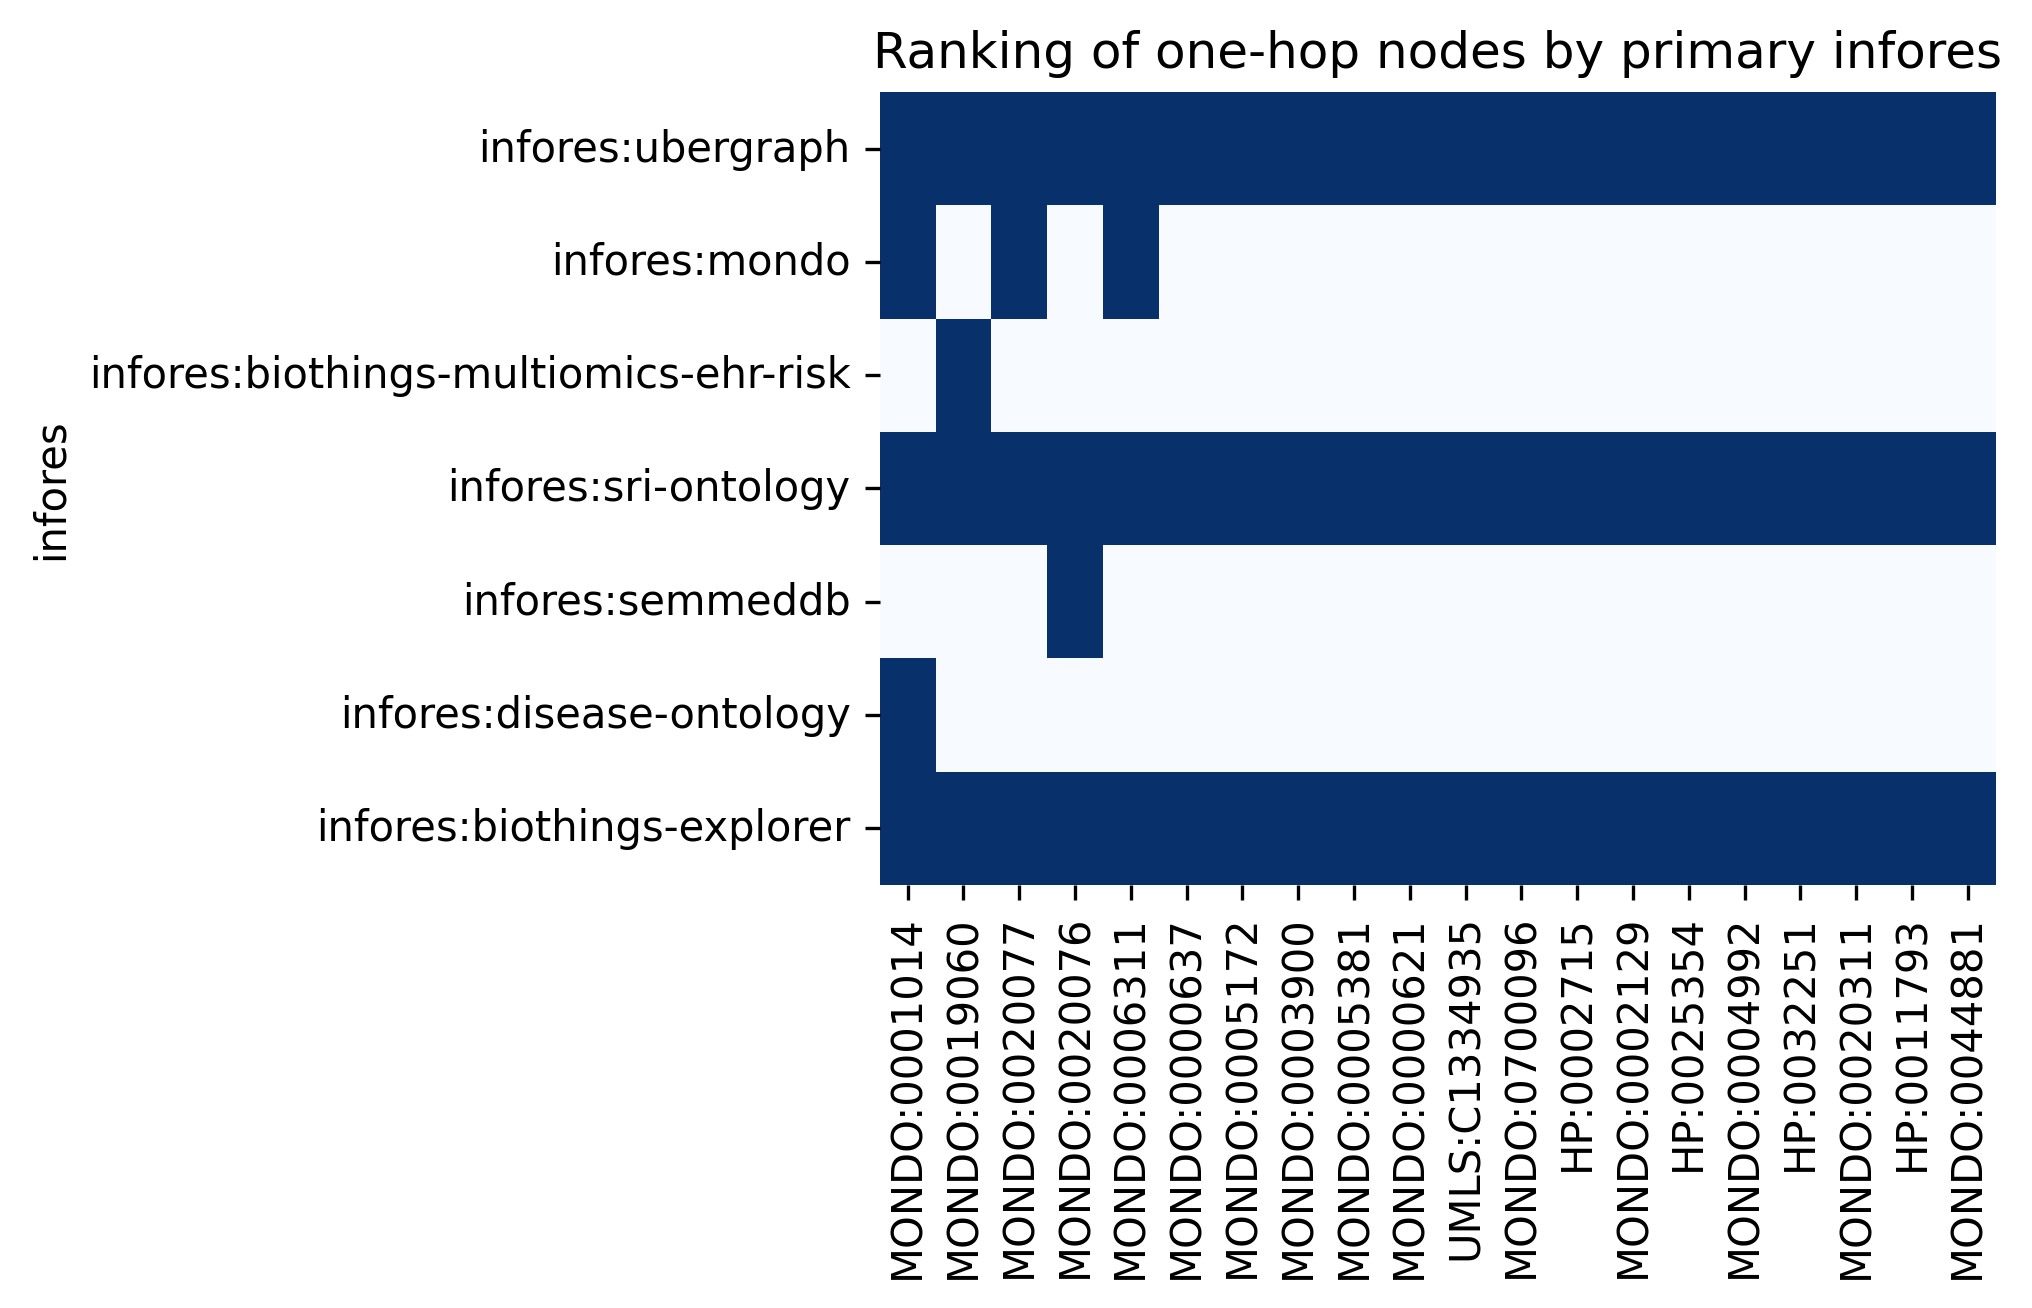

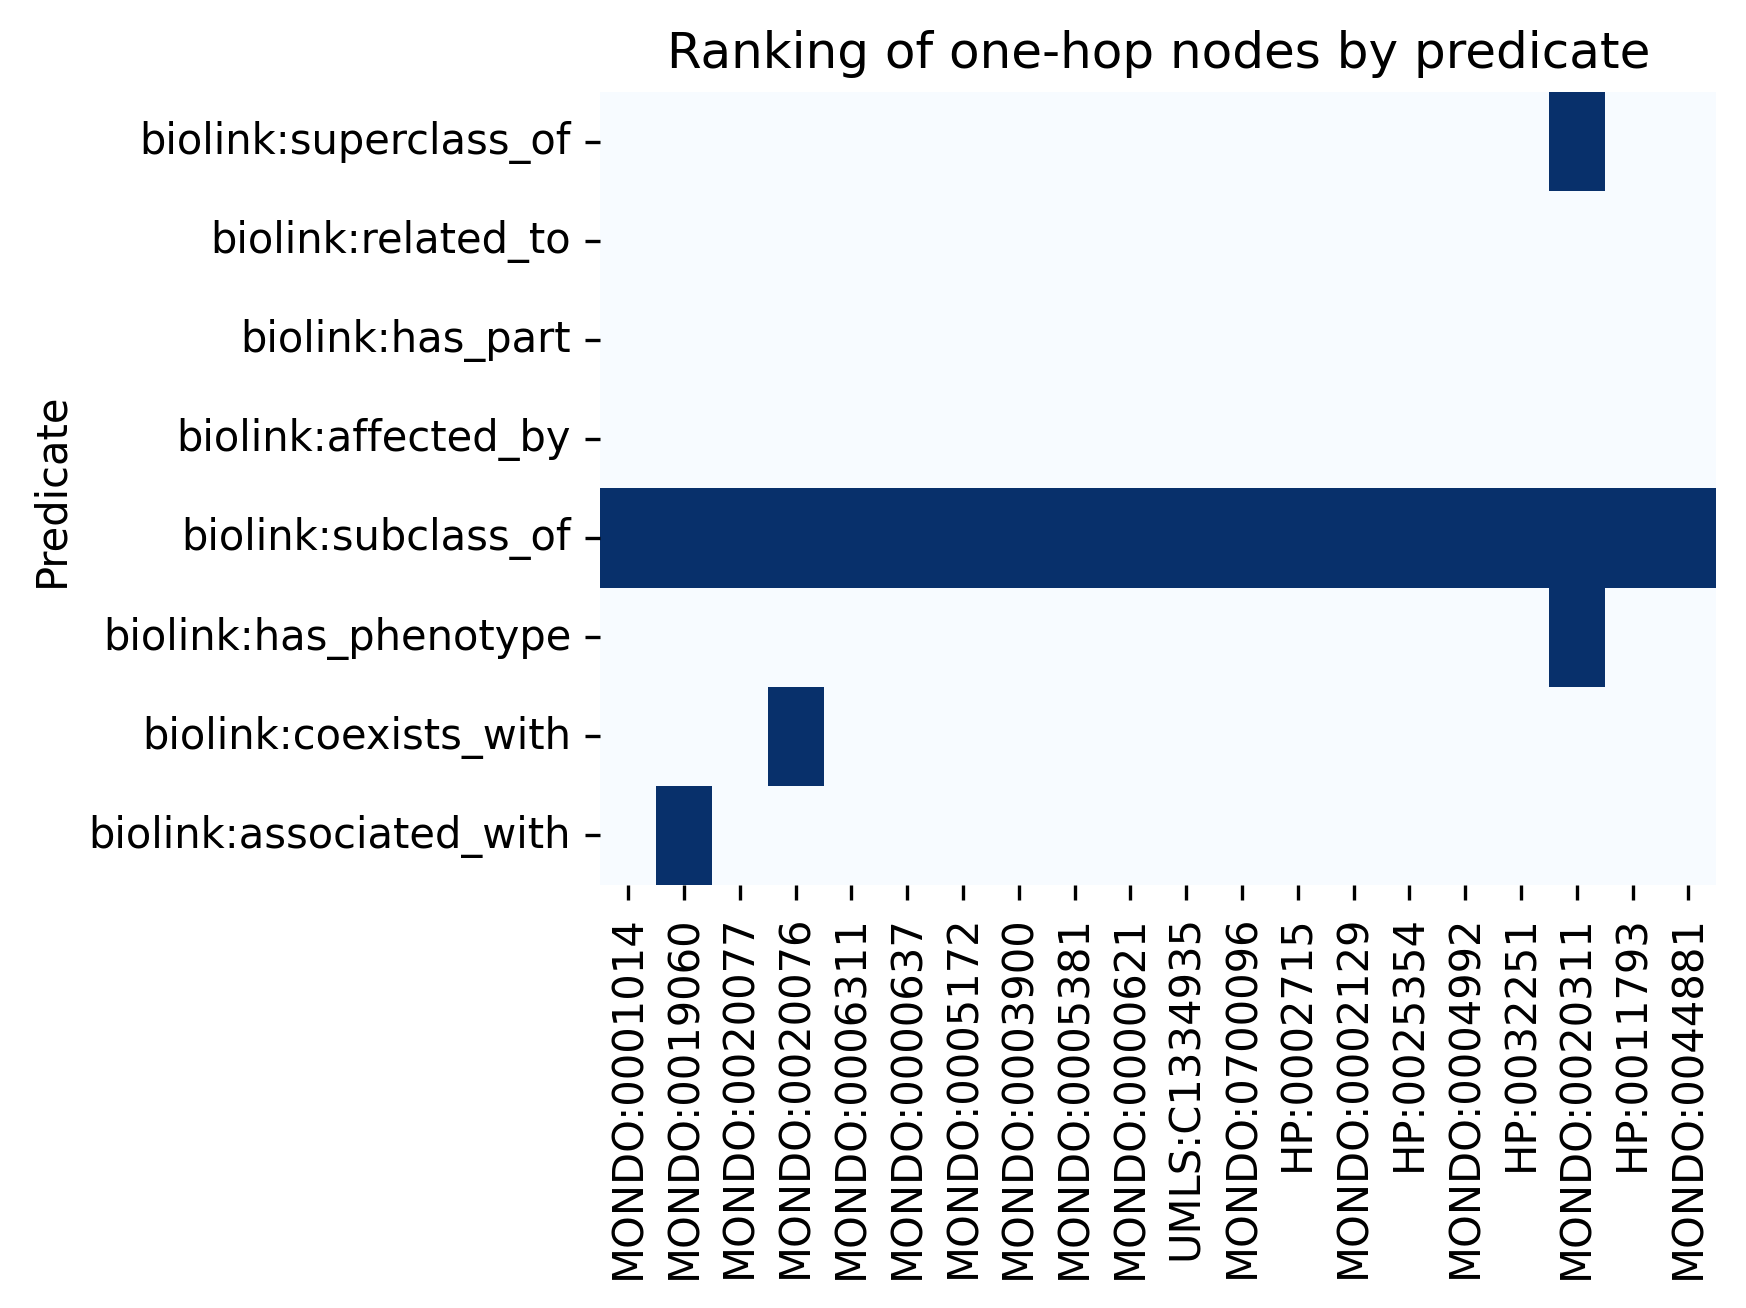

In [113]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"

# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, num_of_nodes = 20, input_query = input_node1_id)

In [9]:
# End of the example